In [22]:
import cv2

In [23]:
extraction_path = r"C:\Users\HARISH A K\Desktop\python\Deep_Learning\Deep_learning_projects\Living_detection\extraction_frames"

In [27]:
import cv2
import os

# Path to the video file
video_path = r"C:\Users\HARISH A K\Desktop\python\Deep_Learning\Deep_learning_projects\Living_detection\data.mp4"

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the frames per second (fps) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the directory where frames will be saved
extraction_path = r"C:\Users\HARISH A K\Desktop\python\Deep_Learning\Deep_learning_projects\Living_detection\extraction_frames"

# Initialize frame counter
frame_counter = 1

# Loop through the video frames
while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Save the frame with a filename like "frame1.jpg" in the specified directory
    frame_filename = os.path.join(extraction_path, f'frame{frame_counter}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_counter += 1

# Release the video capture object
cap.release()

print(f"The frames per second (fps) of the video is: {fps}")

The frames per second (fps) of the video is: 24


In [28]:
print(frame_counter)

241


# (i) Object Detection and Bounding Boxes

# (ii) Counting People

# (iii) Screen Time Calculation


In [29]:
# yolov3 have single output layer for probability distribution and box predictions.
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
# weights - neural network parameters like bias,propagation etcc.
# cfg - configuration , architecture

YOLOv3 feature extractor called DARKNET-53 ( has 52 convolutions ), skip connections and 3 predictions head for each image.
1. applies single neurl network
2. divides image into grid cells.
3. Give probabilities for each cell
4. predictics boxes, choose the box and box which has best probability

total layers 106 detections are made at layers 82,94,106 

version3 have 
Residual blocks -
skip connections - 
UP- sampling - 

CNN layers followed by 
Batch normalization - 
leaky Relu activation function

no max pooling , it have CNN (filters 2x2, stride 2) 4x4 matrix become 2x2 by adding 4 cells to one, in max pooling it will take max value from each 4 cell to form 2x2.

Network input - (n,416,416,3) , no. of images, height, weight, RGB
height and widthh can be change to numbers that are divisible by 32 

Network strides
32 -  output 13x13 (large objects)
16 -  output 26x26 (medium objects)
8 -  output 52x52 (small objects)

applies CNN to input-> downsamples 	image at 3 scales (82,94,106)-> 1x1 kernels are applied to grid of cells-> 1 cell resposible for detecting 1 object-> each scale have 3 anchors totally 9 which predict bounding box

In [30]:
extraction_path=r"C:\Users\HARISH A K\Desktop\python\Deep_Learning\Deep_learning_projects\Living_detection\extraction_frames"

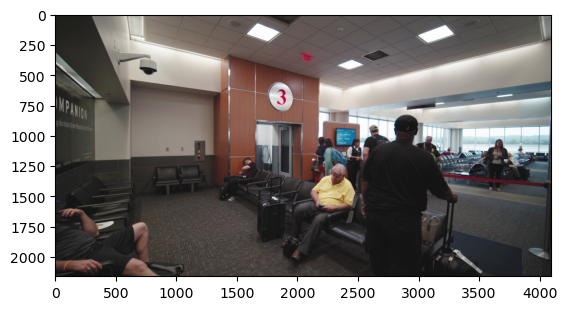

In [31]:
import matplotlib.pyplot as plt
img = plt.imread(r"C:\Users\HARISH A K\Desktop\python\Deep_Learning\Deep_learning_projects\Living_detection\extraction_frames\frame20.jpg")   # reading image using its name
plt.imshow(img)

Darknet-53 Backbone:

YOLOv3 uses a neural network backbone called "Darknet-53." This backbone is a deep convolutional neural network that consists of 53 convolutional layers. It is responsible for feature extraction from the input image.
Feature Pyramid Network (FPN):

YOLOv3 incorporates a Feature Pyramid Network to extract features at multiple scales. This helps in detecting objects of various sizes in the image. FPN is used to capture features at different resolutions.
Detection at Multiple Scales:

YOLOv3 performs detection at three different scales (i.e., small, medium, and large) using feature maps at different resolutions. This allows it to detect objects of different sizes effectively.
Detection Head:

Each detection scale has its own detection head, consisting of convolutional layers and anchor boxes. Anchor boxes are used to predict bounding boxes for different object classes and objectness scores.
Predictions:

For each anchor box at each scale, YOLOv3 predicts:
The coordinates (x, y, width, height) of the bounding box.
The confidence score, which represents how likely the bounding box contains an object.
Class probabilities for multiple object classes.
Non-Maximum Suppression (NMS):

After predictions are made at multiple scales, YOLOv3 applies non-maximum suppression to filter out duplicate detections and keep the most confident ones.
Output Format:

The final output of YOLOv3 is a list of bounding boxes, each associated with a class label and a confidence score. It can detect multiple objects of different classes in a single pass.
Loss Function:

YOLOv3 uses a combination of loss functions, including localization loss, confidence loss, and class prediction loss, to train the model.
Anchors:

YOLOv3 uses predefined anchor boxes with different aspect ratios and scales to predict bounding boxes accurately for various object shapes.

# Human detection

In [32]:
import numpy as np

current_person_id = 0
printed_person_ids = set() # to keep track on already printed persons set is used because of uniqueness
class_ids=[] # 0 for people in the model
data=[] # details of detected persons and their frames

for i in range(1, frame_counter):

    frame_path = extraction_path + "\\frame%d.jpg" % i
    image = cv2.imread(frame_path)
    height, width = image.shape[:2]

    # Preprocess the frames for YOLOv3
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
   # 0.00392: This is a scaling factor. It's used to scale pixel values ( adjusting pixel values in a image) in the image. In YOLOv3, 
   # images are usually preprocessed by dividing pixel values by 255.0, but this factor helps fine-tune the scaling
    # open cv loads BGR so swapRB=True
    
    net.setInput(blob) # sets input for the network

    # Get output
    outs = net.forward(net.getUnconnectedOutLayersNames()) # performs forward pass and gets the output.
        # outs =    [x1, y1, width1, height1, confidence1, class_id1]... for all layers

    
    # Thresholds
    conf_threshold = 0.5
    nms_threshold = 0

    confidences = []
    boxes = []

    # Detection process
    for out in outs: # iterate each output layer
        for detection in out:  # iterate each detected object in that output layer
            scores = detection[5:] # scores contains the confidence scores for different classes
            class_id = np.argmax(scores) # class_id with the highest confidence
            confidence = scores[class_id] # confidence score for class_id which may person,or object, person's class=0

            if confidence > conf_threshold and class_id == 0:  # checks confidence > threshold class_id = 0 means people
                center_x = int(detection[0] * width) # horizontal center Calculates the x-coordinate of the center of the bounding box in pixels.
                center_y = int(detection[1] * height) #  vertical center Calculates the y-coordinate of the center of the bounding box in pixels.
                w = int(detection[2] * width) # width
                h = int(detection[3] * height) # height
                x = int(center_x - w / 2) # x-coordinate top left corner of bounding box
                y = int(center_y - h / 2) # y-coordinate top left corner of bounding box

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

                # class_ids (the class ID, which is 0 for people), confidences (the confidence score),
                # and boxes (the coordinates and dimensions of the bounding box). 
                # This data can be used for further processing or visualization of the detected people

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    # ndices holds the indices of the bounding boxes that represent distinct and confident detections

    # Reset the person ID when it reaches 2
    current_person_id = 0

    # Draw bounding boxes without tracking
    for index in indices:
        x, y, w, h = boxes[index]
        color = (0, 255, 0)  # Green color
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
        
        # Increment the person ID
        current_person_id += 1
       # max_person_id = max(max_person_id, current_person_id)  # Update max_person_id

        # Append the data as a dictionary
        data.append({
            "Frame Name": f"frame{i}.jpg",
            "Person ID": current_person_id,
        })

        printed_person_ids.add(current_person_id)

    # Display the frame with bounding boxes
    resized_image = cv2.resize(image, (800, 600))
    cv2.imshow("Bounding box", resized_image)

    key = cv2.waitKey(1)

    if key == ord('q'):
        break

cv2.destroyAllWindows()

In [41]:
print("printed person id ",printed_person_ids)
print("class_id ",class_ids)
print("Data ",data)

printed person id  {1, 2, 3, 4, 5, 6, 7, 8}
class_id  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Counting people

In [35]:
print("total count of people is ",len(printed_person_ids)) # count total number of ids assigned

total count of people is  8


# Calculate screen time of each person

In [32]:
# WORST QUALITY
# from pytube import YouTube as yt
# video_link = "https://www.youtube.com/watch?v=9h2bKsJ7j_c"
# vid = yt(video_link)
# stream = vid.streams.first()
# stream.download()


In [36]:
import pandas as pd
df=pd.DataFrame(data)
df

,Frame Name,Person ID
0,frame1.jpg,1
1,frame1.jpg,2
2,frame1.jpg,3
3,frame1.jpg,4
4,frame1.jpg,5
...,...,...
1288,frame240.jpg,2
1289,frame240.jpg,3
1290,frame240.jpg,4
1291,frame240.jpg,5


In [37]:
csv_file = 'data1.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file, index=False)

data = pd.read_csv('data1.csv')

In [38]:
first_person = len(df[df['Person ID'] == 1])

# Count rows where Class is 'Both in the frame'
p2 = len(df[df['Person ID'] == 2])
p3 = len(df[df['Person ID'] == 3])
p4 = len(df[df['Person ID'] == 4])
p5 = len(df[df['Person ID'] == 5])
p6 = len(df[df['Person ID'] == 6])
p7 = len(df[df['Person ID'] == 7])
p8 = len(df[df['Person ID'] == 8])


print(f"Count of 'person 1': {first_person} frames ")
print(f"Count of 'person 2': {p2} frames" )
print(f"Count of 'person 3': {p3} frames" )
print(f"Count of 'person 4': {p4} frames" )
print(f"Count of 'person 5': {p5} frames" )
print(f"Count of 'person 6': {p6} frames" )
print(f"Count of 'person 7': {p7} frames" )
print(f"Count of 'person 8': {p8} frames" )

Count of 'person 1': 240 frames 
Count of 'person 2': 240 frames
Count of 'person 3': 240 frames
Count of 'person 4': 240 frames
Count of 'person 5': 209 frames
Count of 'person 6': 104 frames
Count of 'person 7': 19 frames
Count of 'person 8': 1 frames


In [40]:
first_person/fps

10.0